## Loading and preparing data

In [13]:
import json
import pandas as pd
import numpy as np
import re
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
import time
import torch
# import transformers
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer # type: ignore
from sentence_transformers.quantization import quantize_embeddings

embedding_path = "../prompt-sentences-main/prompt_sentences-all-minilm-l6-v2.json"

with open(embedding_path) as f:
    data = json.load(f)
    
positive_values = data["positive_values"]
negative_values = data["negative_values"]

## Functions for converting the dataset into different data formats

In [14]:
def create_dictionary_data(positive_values, index):
    positive_value_dict = {}
    data_frame = None
    for positive_value in positive_values:
        label = positive_value["label"]
        prompts = positive_value["prompts"]
        for prompt in prompts:
            content = prompt["text"]
            embedding = prompt["embedding"]
            for dim in range(len(embedding)):
                positive_value_dict[f"embedding_dim_{dim}"] = embedding[dim]
            positive_value_dict["prompt"] = content
            positive_value_dict["label"] = label
            local_data_frame = pd.DataFrame(positive_value_dict, index=[index])
            if data_frame is None:
                data_frame = pd.concat([local_data_frame])
            else:
                data_frame = pd.concat([data_frame, local_data_frame])
    return data_frame

def build_embedding_data_frame(positive_values, create_dictionary_data):
    index = 0
    dict_data_frame = create_dictionary_data([positive_values[0]], 0)
    embeddings_data_frame = pd.concat([dict_data_frame])
    for positive_value in positive_values:
        index = index + 1
        local_dict_data_frame = create_dictionary_data([positive_value], index)
        embeddings_data_frame = pd.concat([embeddings_data_frame, local_dict_data_frame])
    return embeddings_data_frame
    

## More preparation

In [15]:
dataset = build_embedding_data_frame(positive_values, create_dictionary_data)    
enumerate_label_bijection_map = {}
label_list = dataset["label"]
unique_elements = list(set(label_list))

for i, label in enumerate(unique_elements):
    enumerate_label_bijection_map[f"{i}"] = label
    enumerate_label_bijection_map[label] = f"{i}"
    
columns = [f"embedding_dim_{index}" for index in range(0,384)]
dataset = dataset.reset_index()
dataset = dataset.drop(480).reset_index()
# dataset = dataset.sample(frac=1, random_state=42)
X = np.array(dataset[columns])
# X_norm = normalize(X)

## PCA (not in use)

In [16]:
def get_PCA(X):
    pca_X = X
    pca = PCA(n_components=2)
    pca.fit(pca_X)
    print(pca.explained_variance_ratio_)
    print(pca.singular_values_)
    return pca, pca_X

## SVD (not in use)

In [17]:

def get_SVD(data):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    svd = TruncatedSVD(n_components=2)  # retain 2 singular values
    X_reduced = svd.fit_transform(X_scaled)

    print("Explained variance ratio: ", svd.explained_variance_ratio_)

    # plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
    # plt.xlabel("Principal Component 1")
    # plt.ylabel("Principal Component 2")
    # plt.title("Value data reduced")
    # plt.show()
    return svd, X_reduced

## Component Reduction Method

In [29]:
def component_reduction(component_reduction_method, X_data, do_scale):
    if do_scale:
        scaler = StandardScaler()
        X_data = scaler.fit_transform(X_data)
    reduced_data = None
    if component_reduction_method == "pca":
        reduced_data = PCA(n_components=2, random_state=42).fit_transform(X_data)
    else:
        reduced_data = TruncatedSVD(n_components=2, random_state=42).fit_transform(X_data)
    return reduced_data

## Kmeans

In [18]:
kmeans = KMeans(init="k-means++", n_clusters=57, random_state=42, n_init=25)

## Kmedoids

In [19]:
kmedoids = KMedoids(n_clusters=57, random_state=42)

## Visualization

In [68]:

def vizualize_clusters(cluster_method, component_reduction_method, X_data, do_scale):
    reduced_data = component_reduction(component_reduction_method, X_data, do_scale)
    print(reduced_data.shape)
    # kmeans = KMeans(init="k-means++", n_clusters=57, n_init=4)
    cluster_method.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
    Z = cluster_method.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
    centroids = cluster_method.cluster_centers_
    plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=30,
    linewidths=3,
    color="w",
    zorder=10,
)
    title_suffix =  " based on " + component_reduction_method
    title =  "k-means" + title_suffix if "kmeans" in str(type(cluster_method)) else "k-medoids" + title_suffix
    plt.title(
        title
)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    return cluster_method, reduced_data

## Utils

In [21]:
def find_nan_indices(arr):
    indices = []
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if np.isnan(arr[i, j]):
                indices.append((i, j))
    return indices

In [22]:
def convert_array(arr, mapping):
    arr = arr.flatten()
    result = np.array([mapping[str(i)] for i in arr])
    result = result.reshape(arr.shape)
    return result

# list_from_pred = (list(convert_array(pred, enumerate_label_bijection_map)))
# list_from_dataset = (list(dataset["label"]))

# count = 0
# for a, b in zip(list_from_pred, list_from_dataset):
#     if a == b:
#         count = count + 1
#     print(a, "--", b)
# print(count)

In [23]:
def split_into_sentences(prompt):
    """
    Function that splits the input text into sentences based
    on punctuation (.!?). The regular expression pattern
    '(?<=[.!?]) +' ensures that we split after a sentence-ending
    punctuation followed by one or more spaces.

    Args:
        prompt: The entered prompt text.

    Returns:
        A list of extracted sentences.

    Raises:
        Nothing.
    """
    sentences = re.split(r'(?<=[.!?]) +', prompt)
    return sentences

In [24]:
def load(model_path = "/Users/tiagomachado/Documents/GitHub/MyProjects/models_for_experimentation/embedders/all-MiniLM-L6-v2"):
	model = SentenceTransformer(model_path)
	return model

(756, 2)


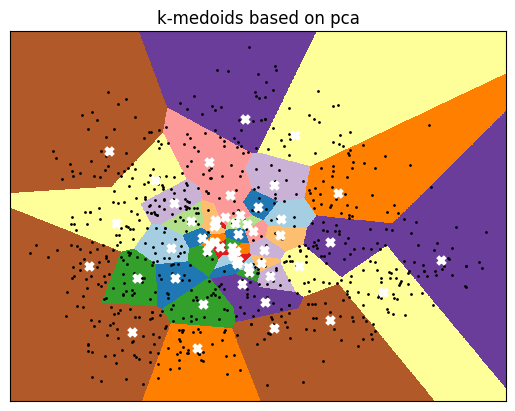

In [93]:
cluster_method, reduced_data = vizualize_clusters(kmedoids, component_reduction_method="pca", X_data=X, do_scale=True)

In [26]:
sentences = split_into_sentences("Act as a professional data scientist with 20 years of experience studying consumer behavior. Here is a csv file with bank records from 800,000 Americans. Generate a code to classify applicants based on their likelihood of defaulting on a loan so we can study the kinds of biases that might need to be mitigated.")

In [27]:
model = load()

In [86]:
encoded_0 = model.encode(sentences[0])
encoded_1 = model.encode(sentences[1])
encoded_2 = model.encode(sentences[2])
encodes = np.array([encoded_0, encoded_1, encoded_2], dtype='float64')
encodes.shape

(3, 384)

In [87]:
encodes.dtype

dtype('float64')

In [88]:
data_r = component_reduction(component_reduction_method="pca", X_data=encodes, do_scale=True)
data_r.shape

(3, 2)

In [94]:
values = cluster_method.predict(data_r)

In [95]:
values

array([55, 43, 46])

In [96]:
print(enumerate_label_bijection_map["55"])
print(enumerate_label_bijection_map["43"])
print(enumerate_label_bijection_map["46"])

productivity
explainability
power
